In [1]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Start date
start = '2009-06-10'
## CoinMetrics data
data = pd.read_csv('https://community-api.coinmetrics.io/v2/assets/btc/metricdata.csv?metrics=PriceUSD,CapMrktCurUSD,CapRealUSD,TxTfrValAdjUSD,FeeTotUSD,FeeTotNtv,IssContNtv,BlkCnt,DiffMean,SplyCur,AdrActCnt&start='+start, index_col = 0, parse_dates=True)
# Remove time-zone stamp from index
data.index = data.index.tz_convert(None)

## Blockchain.com wallets data
timespan = 'all'
w_data = pd.read_csv('https://api.blockchain.info/charts/my-wallet-n-users?timespan='+timespan+'&format=csv', header=None, infer_datetime_format =True)
w_data.columns = ['Date', 'nWallets']
## Parsing date
w_data['Date'] = w_data['Date'].apply(lambda x: datetime.strptime(str(x).split(' ')[0], '%Y-%m-%d'))
## Eliminate 'intra day' data
w_data['Date'] = w_data['Date'].drop_duplicates(keep = 'last')
w_data = w_data[w_data['Date'].notnull()]
## Date to index
w_data.set_index('Date', inplace=True, drop=True)
## Merge dataframes
data = pd.concat([data, w_data], axis=1, sort=True, join='outer')
## Fill empty cells
data['nWallets'] = data['nWallets'].ffill(axis = 0)

## Gompertz Sigmoid
data['G_Sigmoid'] = data['SplyCur'] * np.log(21000000 / data['SplyCur'])

data = data.iloc[720:]

<ipython-input-2-2fe5ccb16dd2>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  w_data.dropna(thresh= 3, inplace=True)


0.7607859940804411
0.7910481173672552


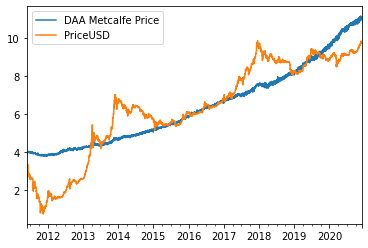

In [2]:
## Metcalfe's Law

## Daily Active Addresses
data['AA Pairs'] = data['AdrActCnt'] * (data['AdrActCnt'] - 1) / 2
data['DAA Metcalfe (log)'] = np.log(data['AA Pairs']) / data['G_Sigmoid']

## Transaction pairs (mil)
data['Wlt Pairs'] = data['nWallets'] * (data['nWallets'] - 1) / 2
data['Wlt Metcalfe (log)'] = np.log(data['Wlt Pairs']) / data['G_Sigmoid']


## Working Data for Linear Regression
w_data = data[['DAA Metcalfe (log)', 'Wlt Metcalfe (log)', 'PriceUSD']]
w_data.dropna(thresh= 3, inplace=True)

log_wlt = w_data['Wlt Metcalfe (log)'].values.reshape(-1, 1)
log_daa = w_data['DAA Metcalfe (log)'].values.reshape(-1, 1)
log_price = np.log(w_data['PriceUSD']).values.reshape(-1, 1)

## Linear Regression
daa_reg = LinearRegression().fit(log_daa, log_price)
wlt_reg = LinearRegression().fit(log_wlt, log_price)

daa_a = daa_reg.coef_[0][0]
daa_b = daa_reg.intercept_[0]

wlt_a = wlt_reg.coef_[0][0]
wlt_b = wlt_reg.intercept_[0]

data['DAA Metcalfe Price'] = np.exp(data['DAA Metcalfe (log)'] * daa_a + daa_b)
data['Wlt Metcalfe Price'] = np.exp(data['Wlt Metcalfe (log)'] * wlt_a + wlt_b)

print(daa_reg.score(log_daa, log_price))
print(wlt_reg.score(log_wlt, log_price))

np.log(data[['DAA Metcalfe Price', 'PriceUSD']]).plot()
#np.log(data[['Wlt Metcalfe Price', 'PriceUSD']]).plot()
#data['Metcalfe (log)'].plot()

file = data[['DAA Metcalfe Price', 'Wlt Metcalfe Price']].to_csv('Data/Metcalfe.csv')

In [ ]:
wlt_b